# How to pay for a war: part 3

### Experiment 1: Roll-over risk

Let $T_t$ denote tax collections, $\beta$ a discount factor, $b_{t,t+1}$ time $t+1$ goods that the government promises to pay at $t$, $G_t$ government purchases, $p_{t,t+1}$ the number of time $t$ goods received per time $t+1$ goods promised. The stochastic  process of government expenditures is exogenous. The government's problem is to choose a plan for taxation and borrowing $\{b_{t+1}, T_t\}_{t=0}^\infty$ to minimize

$$ E_0 \sum_{t=0}^\infty \beta^t T_t^2  $$
subject to the constraints
\begin{align}
 T_t + p_{t,t+1} b_{t,t+1} & = G_t + b_{t-1,t} \\
 G_t &  = U_{g,t} z_t \\
 z_{t+1} & = A_{22,t} z_t + C_{2,t} w_{t+1} 
\end{align}

where $w_{t+1} \sim {\cal N}(0,I)$. The variables $T_t, b_{t, t+1}$ are *control* variables chosen at $t$,
while $b_{t-1,t}$ is an endogenous state variable inherited from the past at time $t$ and $p_{t,t+1}$ is an exogenous state variable at time $t$. This is the same set-up as used [in this notebook](http://nbviewer.jupyter.org/github/QuantEcon/TaxSmoothing/blob/master/Tax_Smoothing_1.ipynb). We will consider a situation in which the government faces "roll-over risk". Specifically, we shut down the government's ability to borrow in one of the Markov states. 

A first thought for how to implement this would be to allow $p^t_{t+1}$ to vary over time with:
$$ p^t_{t+1} = \beta $$

in Markov state 1 and

$$ p^t_{t+1} = 0 $$ in Markov state 2. Consequently, in the second Markov state the government is unable to borrow, and the budget constraint becomes $T_t = G_t + b_{t-1,t}$. 

However, if this is the only adjustment we make, the government will not set $b_{t,t+1} = 0$ as we desire. It has an incentive to set $b_{t,t+1}$ to a large negative number in state 2. While this does not affect the tax payment in period $t$, it means that the government enters period $t+1$ with high assets. Thus, we must implement "roll-over risk" some other way.

To force the government to set $b_{t,t+1} = 0$, we can instead  extend the model to have four Markov states:
1. Good today, good yesterday
2. Good today, bad yesterday
3. Bad today, good yesterday
4. Bad today, bad yesterday

(where good is the state where the government can issue debt and bad is the state where the government can't issue debt)

We now set $$ p^t_{t+1} = \beta $$ in all states. However, we put a large penalty on the $b_{t-1,t}$ element of the state vector in states 2 and 4. This will prevent the government from wishing to issue any debt in states 3 or 4, as they will face a large penalty for doing so in the next period. The transition matrix for this formulation is:

$$ \Pi = \begin{bmatrix} 0.95 & 0 & 0.05 & 0 \\
                         0.95 & 0 & 0.05 & 0 \\
                         0 & 0.9 & 0 & 0.1 \\
                         0 & 0.9 & 0 & 0.1 \\
\end{bmatrix} $$
This transition matrix ensures that the Markov state cannot move, for example, from state 3 to state 1. As state 3 is "bad today", the next period cannot have "good yesterday".

In [112]:
import quantecon as qe
import numpy as np
import matplotlib.pyplot as plt
from lq_markov import *
%matplotlib inline

In [166]:
# Model parameters 
beta, Gbar, rho, sigma = 0.95, 5, 0.8, 1

# Basic model matrices
A22 = np.array([[1,0],[Gbar, rho],])
C2 = np.array([[0], [sigma]])
Ug = np.array([[0,1]])

# LQ framework matrices
A_t = np.zeros((1,3))
A_b = np.hstack((np.zeros((2,1)),A22))
A = np.vstack((A_t,A_b))

B = np.zeros((3,1))
B[0,0] = 1

C = np.vstack((np.zeros((1,1)),C2))

Sg = np.hstack((np.zeros((1,1)),Ug))
S1 = np.zeros((1,3))
S1[0,0] = 1
S = S1 + Sg

R = np.dot(S.T,S)

# Large penalty on debt in R2 to prevent borrowing in bad state
R1 = np.copy(R)
R2 = np.copy(R)
R1[0,0] = R[0,0] + 1e-9
R2[0,0] = R[0,0] + 1e12

M = np.array([[-beta]])
Q = np.dot(M.T,M)
W = np.dot(M.T,S)

# Create namedtuple to keep the R,Q,A,B,C,W matrices for each state of the world
world = namedtuple('world', ['A', 'B', 'C', 'R', 'Q', 'W'])

Pi = np.array([[0.95,0,0.05,0],[0.95,0,0.05,0],[0,0.9,0,0.1],[0,0.9,0,0.1]])

#Sets up the four states of the world
v1 = world(A=A,B=B,C=C,R=R1,Q=Q,W=W)
v2 = world(A=A,B=B,C=C,R=R2,Q=Q,W=W)
v3 = world(A=A,B=B,C=C,R=R1,Q=Q,W=W)
v4 = world(A=A,B=B,C=C,R=R2,Q=Q,W=W)

MJLQBarro = LQ_Markov(beta,Pi,v1,v2,v3,v4)

This model is simulated below, using the same process for $G_t$ as in the previous notebook. When $ p^t_{t+1} = \beta $ government debt fluctuates around zero. The spikes in the series for taxation show periods when the government is unable to access financial markets: positive spikes occur when debt is positive, and the government must raise taxes in the current period. 

Negative spikes occur when the government has positive asset holdings. An inability to use financial markets in the next period means that the government uses those assets to lower taxation toay.

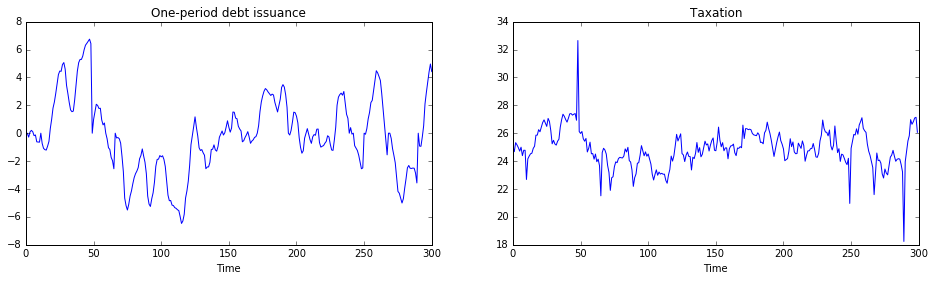

In [167]:
x0 = np.array([[0,1,25]])
T = 300
x,u,w,state = MJLQBarro.compute_sequence(x0,ts_length=T)

# Calculate taxation each period from the budget constraint and the Markov state
tax = np.zeros([T,1])
for i in range(T):
    tax[i,:] = S.dot(x[:,i]) + M.dot(u[:,i])

#Plot of debt issuance and taxation
plt.figure(figsize=(16,4))
plt.subplot(121)
plt.plot(x[0,:])
plt.title('One-period debt issuance')
plt.xlabel('Time')
plt.subplot(122)
plt.plot(tax)
plt.title('Taxation')
plt.xlabel('Time')

We can adjust the model such that, rather than having debt fluctuate around zero, the government is always a debtor, unless they cannot borrow. To do this, we simply raise $ p^t_{t+1}$ to  $\beta + 0.02 = 0.97 $. 

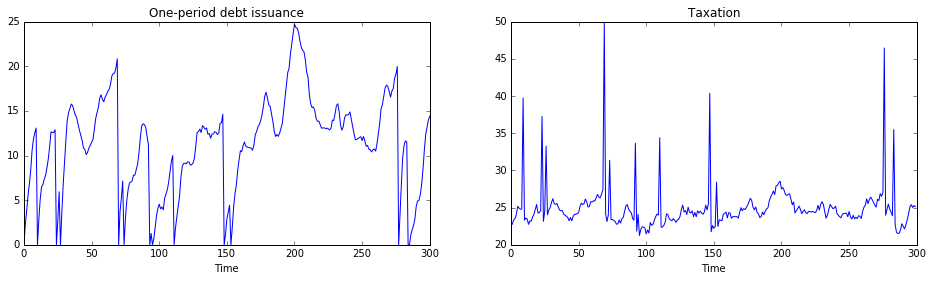

In [169]:
M = np.array([[-beta-0.02]])

Q = np.dot(M.T,M)
W = np.dot(M.T,S)

#Sets up the four states of the world
v1 = world(A=A,B=B,C=C,R=R1,Q=Q,W=W)
v2 = world(A=A,B=B,C=C,R=R2,Q=Q,W=W)
v3 = world(A=A,B=B,C=C,R=R1,Q=Q,W=W)
v4 = world(A=A,B=B,C=C,R=R2,Q=Q,W=W)

MJLQBarro2 = LQ_Markov(beta,Pi,v1,v2,v3,v4)
x,u,w,state = MJLQBarro2.compute_sequence(x0,ts_length=T)

# Calculate taxation each period from the budget constraint and the Markov state
tax = np.zeros([T,1])
for i in range(T):
    tax[i,:] = S.dot(x[:,i]) + M.dot(u[:,i])

#Plot of debt issuance and taxation
plt.figure(figsize=(16,4))
plt.subplot(121)
plt.plot(x[0,:])
plt.title('One-period debt issuance')
plt.xlabel('Time')
plt.subplot(122)
plt.plot(tax)
plt.title('Taxation')
plt.xlabel('Time')

With the lower interest rate, the government has an incentive to increase debt over time. However, with "roll-over risk", debt is periodically reset to zero, and taxes spike up. Consequently, the government is wary of letting debt get too high, due to the high cost of a "sudden stop".